In [50]:
from types import SimpleNamespace
import matplotlib.pyplot as plt
import numpy as np
import csv
import os
from collections import OrderedDict

from main import train_model, AudioFeatureDataset

In [10]:
dataset = AudioFeatureDataset(mode="test", normalize_features=False)

(array([49., 60., 99., 81., 70., 59., 69., 59., 36., 34., 23., 24., 16.,
         8.,  8., 17., 11.]),
 array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
        16., 17., 18., 19., 20.]),
 <BarContainer object of 17 artists>)

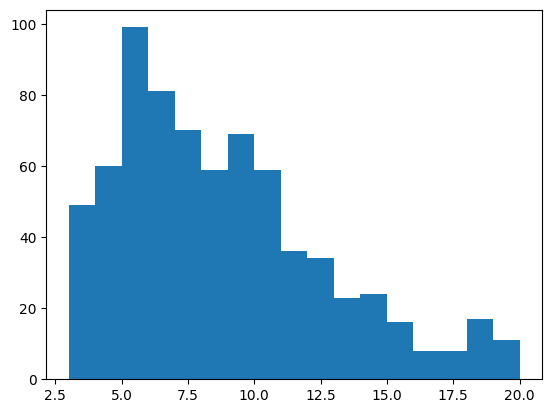

In [17]:
album_lengths = dataset.album_lengths

# create histogram of album lengths
count, bins = np.histogram(album_lengths, bins=17)
plt.hist(bins[:-1], bins, weights=count)

In [45]:
file_path = "/media/vincent/storage/data/fma/data/fma_metadata/raw_tracks.csv"
album_track_ids = {}
with open(file_path, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        try:
            album_id = int(row["album_id"])
        except:
            #print(row["album_id"])
            continue
        track_id = int(row["track_id"])
        track_number = int(row["track_number"])

        if album_id not in album_track_ids:
            album_track_ids[album_id] = {}
        album_track_ids[album_id][track_number] = track_id
        album_track_ids[album_id]["title"] = row["album_title"]
        album_track_ids[album_id]["artist"] = row["artist_name"]

In [48]:
album_dict = OrderedDict()

for i in range(len(dataset)):
    idx = dataset.album_indices[i]
    album_id = dataset.album_ids[i].item()
    num_tracks = dataset.album_lengths[i].item()
    durations = dataset.durations[idx:idx+num_tracks]
    try:
        album_dict[album_id] = {
            "num_tracks": num_tracks,
            "track_ids": [album_track_ids[album_id][j] for j in range(1, num_tracks+1)],
            "track_durations": durations.tolist(),
            "total_duration": durations.sum().item(),
            "title": album_track_ids[album_id]["title"],
            "artist": album_track_ids[album_id]["artist"]
        }
    except KeyError:
        print(f"Not all tracks found: {album_track_ids[album_id]}")

Not all tracks found: {2: 47628, 'title': 'Clever Elsa', 'artist': 'Clever Elsa', 1: 47629, 0: 51306}
Not all tracks found: {4: 29838, 'title': 'Live on WFMU\'s Evan "Funk" Davies show, May 4th 2010', 'artist': 'White Hills', 3: 29839, 2: 29840, 1: 29841, 0: 29842}


In [49]:
# filter dict so with only albums with at least 5 tracks, but no more than 9 tracks
filtered_album_dict = {k: v for k, v in album_dict.items() if v["num_tracks"] >= 5 and v["num_tracks"] <= 9}
# filter dict so with songs longer than 150 seconds and shorter than 400 seconds
filtered_album_dict = {k: v for k, v in filtered_album_dict.items() if min(v["track_durations"]) > 140 and max(v["track_durations"]) < 420}

## Copy selected tracks to new directory

In [51]:
fma_large_dir = "/media/vincent/storage/data/fma/data/fma_large"
target_dir = "/media/vincent/storage/data/fma/data/survey_selection"

for album_id, album in filtered_album_dict.items():
    print(f"Album: {album['title']} by {album['artist']}")
    # create directory for album
    album_dir = f"{target_dir}/{album_id}"
    try:
        os.mkdir(album_dir)
    except FileExistsError:
        pass
    
    for i, track_id in enumerate(album["track_ids"]):
        print(f"Track {i+1}: {track_id} - {album['track_durations'][i]} seconds")
        track_id_str = str(track_id).zfill(6) + ".mp3"
        dir = track_id_str[:3]
        album_dir = f"{fma_large_dir}/{dir}"
        
        # copy track to new directory
        os.system(f"cp {album_dir}/{track_id_str} {target_dir}/{album_id}/{track_id_str}")

Album: System by Pianochocolate
Track 1: 137215 - 231 seconds
Track 2: 137216 - 232 seconds
Track 3: 137217 - 206 seconds
Track 4: 137218 - 190 seconds
Track 5: 137219 - 287 seconds
Track 6: 137220 - 257 seconds
Track 7: 137221 - 304 seconds
Album: Thru EP by Mind Over Midi
Track 1: 42714 - 158 seconds
Track 2: 42715 - 197 seconds
Track 3: 42716 - 225 seconds
Track 4: 42717 - 228 seconds
Track 5: 42718 - 216 seconds
Track 6: 42719 - 230 seconds
Album: Mystery Pills by Mystery Pills
Track 1: 74002 - 301 seconds
Track 2: 91468 - 177 seconds
Track 3: 91469 - 282 seconds
Track 4: 91470 - 224 seconds
Track 5: 91471 - 218 seconds
Album: Sláinte Mohr by Sláinte
Track 1: 38831 - 156 seconds
Track 2: 38832 - 305 seconds
Track 3: 38833 - 200 seconds
Track 4: 38834 - 249 seconds
Track 5: 38835 - 273 seconds
Track 6: 38836 - 249 seconds
Album: Time to meet by Pianochocolate
Track 1: 117149 - 261 seconds
Track 2: 117150 - 343 seconds
Track 3: 117151 - 296 seconds
Track 4: 117152 - 283 seconds
Track

## Create survey csv

In [63]:
# create csv top level
np.random.seed(123)
csv_file = f"{target_dir}/survey.csv"
max_num_tracks = max([album["num_tracks"] for album in filtered_album_dict.values()])
modes = ["a-og/b-rand", "a-rand/b-og"]
num_lines = 10

top_row = ["album_id", "title", "artist", "num_tracks", "mode"]  
for i in range(max_num_tracks):
    top_row.append(f"a_track_{i+1}")
for i in range(max_num_tracks):
    top_row.append(f"b_track_{i+1}")

rows = [top_row]

for line in range(num_lines):
    # pick random album
    album_id = np.random.choice(list(filtered_album_dict.keys()))
    album = filtered_album_dict[album_id]
    # convert track ids to strings and pad with zeros (on the left) to length 6
    track_ids = [str(track_id).zfill(6) + ".mp3" for track_id in album["track_ids"]]
    
    mode = np.random.choice(modes)
    
    # create random order of tracks and check if it is different from original order
    while True:
        rand_order = np.random.permutation(album["num_tracks"])
        if not np.array_equal(rand_order, np.arange(album["num_tracks"])):
            break
    
    # create row
    row = [album_id, album["title"], album["artist"], album["num_tracks"], mode]
    padding = ["-"] * (max_num_tracks - album["num_tracks"])
    if mode == "a-og/b-rand":
        row += track_ids + padding
        row += [track_ids[i] for i in rand_order] + padding
    else:
        row += [track_ids[i] for i in rand_order] + padding
        row += track_ids + padding
    
    rows.append(row)

with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(rows)